# Model evaluation with pronatura dataset 


In [ ]:
!pip install tensorflow

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import cv2
import matplotlib.pyplot as plt
#import imutils
import os
import cv2
import datetime
import numpy as np

import matplotlib.pyplot as plt
#from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Flatten,Lambda
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dropout
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import RMSprop

In [6]:
tf.__version__

'2.11.0'

In [218]:
# Model structure
def initialize_base_branch():
    #this is the model used to make the embeddings
    #the input is 128x128x3
    input = Input(shape=(imsize,imsize,3), name="base_input")
    
    vgg = VGG16(weights="imagenet",
            include_top=False,
            input_tensor=input)
    vgg.trainable = False
    # flatten the max-pooling output of VGG
    flatten = vgg.output
    flatten = Flatten()(flatten)
    
    embedding = Dense(2000,activation="relu")(flatten)
    embedding = layers.Dropout(0.3, name="f_dropout")(embedding)
    embedding = Dense(1500,activation="relu")(embedding)
    embedding = layers.Dropout(0.3, name="s_dropout")(embedding)
    embedding = Dense(1000,activation="relu")(embedding)
    embedding = layers.Dropout(0.3, name="t_dropout")(embedding)
    embedding = Dense(1000, name="IMGembedding")(embedding)


    #convolutional feature extractor
    # input
    #Returning a Model, with input and outputs, not just a group of layers.
    return Model(inputs=input, outputs=embedding)
imsize = 224
base_model = initialize_base_branch()

In [219]:
base_model.summary()

Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 base_input (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0  

In [220]:
#imsize = 128
# Using the newly trained model compute the embeddings
# for a number images
A = Input((imsize,imsize,3))
base_model = initialize_base_branch()
m = base_model(A)
trained_model = Model(inputs=A,outputs=m)
trained_model.load_weights("models 2/model_vgg16_v2_26_07_2023.hdf5")

In [221]:
import pandas as pd
#read the individual files
df2 = pd.read_csv("csvs/fm_no_bg.csv")
df2

Unnamed: 0  Unnamed: 0.1  Unnamed: 0.1.1                     img  \
0             0            45              45   frames/frames1/30.jpg   
1             1            92              92   frames/frames2/60.jpg   
2             2           103             103   frames/frames2/90.jpg   
3             3           127             127    frames/frames4/0.jpg   
4             4           134             134   frames/frames4/30.jpg   
..          ...           ...             ...                     ...   
96           96          1013            1013   frames/frames49/0.jpg   
97           97          1020            1020  frames/frames49/30.jpg   
98           98          1031            1031  frames/frames49/60.jpg   
99           99          1033            1033   frames/frames50/0.jpg   
100         100          1051            1051  frames/frames50/60.jpg   

        video  xmax  ymax  xmin  ymin       label  similarity      indv  \
0     frames1   508   432   123   136      Jaguar   28.834324   frames1   
1     frames2   445   357   236   190  not_jaguar   26.585011   frames2   
2     frames2   459   350   231   180  not_jaguar   27.067038   frames2   
3     frames4   944   360   488   114      Jaguar   29.088072   frames4   
4     frames4   759   392   509   195  not_jaguar   27.595686   frames4   
..        ...   ...   ...   ...   ...         ...         ...       ...   
96   frames49   883   597   736   375  not_jaguar   27.236961  frames49   
97   frames49   927   576   665   473  not_jaguar   29.226276  frames49   
98   frames49   624   671    66   378      Jaguar   28.594070  frames49   
99   frames50   903   606   611   484  not_jaguar   26.954906  frames50   
100  frames50   687   644   259   479  not_jaguar   28.316862  frames50   

                     rem_back  
0     back_rem/frames1_30.jpg  
1     back_rem/frames2_60.jpg  
2     back_rem/frames2_90.jpg  
3      back_rem/frames4_0.jpg  
4     back_rem/frames4_30.jpg  
..                        ...  
96    back_rem/frames49_0.jpg  
97   back_rem/frames49_30.jpg  
98   back_rem/frames49_60.jpg  
99    back_rem/frames50_0.jpg  
100  back_rem/frames50_60.jpg  

[101 rows x 13 columns]

In [222]:
def preprocess_img2(image_path):

    #path = "/content/drive/MyDrive/C-Minds phase 3/data/"
    image = load_img(image_path, target_size=(imsize,imsize))
    image = img_to_array(image)

    return image

In [223]:
def indv_labe2(name):
  #split the invdividual name
   return int(name.replace("frames",""))

In [224]:
labelf = np.array([int(x.replace("frames","")) for x in list(df2["indv"])],dtype=np.int32)

In [225]:
testf = np.array([preprocess_img2(x) for x in list(df2["img"])],dtype='float32')/ 255.0


In [226]:
testf.shape

(101, 224, 224, 3)

In [227]:
sample_size = 5000

X_train_trm = trained_model.predict(testf)
#X_test_trm = trained_model.predict(X_test[:sample_size].reshape(-1,28,28,1))

4/4 [==============================] - 4s 891ms/step


In [228]:
X_train_trm[2]

array([-6.18944168e+01, -6.39092674e+01, -9.97743988e+00,  1.20205450e+01,
        1.83873630e+00, -5.04517860e+01,  8.86043835e+00, -2.09288216e+01,
       -2.25909100e+01,  2.33615341e+01,  5.00287743e+01,  2.52548141e+01,
       -4.39594269e+00, -7.63411179e+01, -4.84771156e+00,  1.28407431e+01,
       -5.12931786e+01,  1.38492794e+01, -2.99159298e+01,  7.58060150e+01,
       -1.42565880e+01,  1.26143360e+01,  2.30864105e+01,  4.65221710e+01,
       -3.14158516e+01,  2.86618137e+01, -9.50236511e+00, -3.32214432e+01,
        1.28087549e+01,  1.92950382e+01, -4.14652348e-01,  2.33863907e+01,
        1.92829189e+01, -2.47784424e+01,  6.62519608e+01,  3.25700493e+01,
       -4.25194588e+01,  4.74071407e+00, -2.90382981e+00, -6.29859467e+01,
       -4.66964960e+00,  2.21798563e+00, -5.21738052e+00,  2.72230577e+00,
        7.23295212e+00, -2.45488243e+01,  4.76274986e+01, -4.68243675e+01,
        4.32885399e+01, -2.75841117e+00, -6.44715118e+01, -4.50981483e+01,
       -1.17977133e+01,  

In [229]:
# import required libraries
import numpy as np
from numpy.linalg import norm
 
# define two lists or array
A = np.array(X_train_trm[3])
B = np.array(X_train_trm[3])
 
#print("A:", A)
#print("B:", B)
 
# compute cosine similarity
cosine = np.dot(A,B)/(norm(A)*norm(B))
print("Cosine Similarity:", cosine)

Cosine Similarity: 1.0000001


In [230]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import pandas as pd

In [231]:
def f(x, y):
    # define two lists or array
    A = np.array(x)
    B = np.array(y)
 
    #print("A:", A)
    #print("B:", B)
 
    # compute cosine similarity
    cosine = np.dot(A,B)/(norm(A)*norm(B))
    #print("Cosine Similarity:", cosine)
    return cosine


In [5]:
# import required libraries
import numpy as np
#from numpy.linalg import norm
np.linalg.norm
# define two lists or array
A = np.array([3,5,1])
B = np.array([111117,300079,104444])
 
#print("A:", A)
#print("B:", B)
 
# compute cosine similarity
cosine = np.dot(A,B)/(np.linalg.norm(A)*np.linalg.norm(B))
print("Cosine Similarity:", cosine)

Cosine Similarity: 0.9732888113888474


In [232]:
matrix_g = np.zeros((X_train_trm.shape[0],X_train_trm.shape[0]))


In [233]:
# we need to iterate over the vector of embedding

for i in range(matrix_g.shape[0]):
    for j in range(X_train_trm.shape[0]):
        matrix_g[i,j] = f(X_train_trm[i],X_train_trm[j])

#>matrix_g

In [234]:

df_cm = pd.DataFrame(matrix_g, index = [i for i in list(df2["indv"])],
                  columns = [i for i in list(df2["indv"])])

In [265]:
df_cm

frames1   frames2   frames2   frames4   frames4   frames5  \
frames1   1.000000  0.999942  0.999945  0.999861  0.999847  0.999549   
frames2   0.999942  1.000000  1.000000  0.999891  0.999870  0.999674   
frames2   0.999945  1.000000  1.000000  0.999890  0.999869  0.999670   
frames4   0.999861  0.999891  0.999890  1.000000  0.999990  0.999793   
frames4   0.999847  0.999870  0.999869  0.999990  1.000000  0.999793   
...            ...       ...       ...       ...       ...       ...   
frames49  0.999443  0.999590  0.999584  0.999751  0.999772  0.999873   
frames49  0.999452  0.999569  0.999564  0.999737  0.999754  0.999910   
frames49  0.999073  0.999219  0.999210  0.999506  0.999532  0.999626   
frames50  0.999188  0.999357  0.999350  0.999572  0.999611  0.999788   
frames50  0.999034  0.999186  0.999177  0.999482  0.999521  0.999618   

           frames5   frames5   frames5   frames6  ...  frames43  frames47  \
frames1   0.999554  0.999648  0.999570  0.999740  ...  0.999986  0.999065   
frames2   0.999682  0.999741  0.999674  0.999818  ...  0.999955  0.999208   
frames2   0.999679  0.999737  0.999670  0.999816  ...  0.999957  0.999200   
frames4   0.999800  0.999882  0.999827  0.999921  ...  0.999884  0.999496   
frames4   0.999803  0.999878  0.999825  0.999919  ...  0.999874  0.999531   
...            ...       ...       ...       ...  ...       ...       ...   
frames49  0.999867  0.999843  0.999839  0.999858  ...  0.999514  0.999831   
frames49  0.999879  0.999823  0.999848  0.999844  ...  0.999521  0.999764   
frames49  0.999582  0.999730  0.999725  0.999604  ...  0.999141  0.999901   
frames50  0.999803  0.999704  0.999724  0.999716  ...  0.999281  0.999815   
frames50  0.999592  0.999685  0.999674  0.999596  ...  0.999112  0.999936   

          frames47  frames48  frames48  frames49  frames49  frames49  \
frames1   0.999588  0.999527  0.999733  0.999443  0.999452  0.999073   
frames2   0.999655  0.999628  0.999791  0.999590  0.999569  0.999219   
frames2   0.999652  0.999622  0.999788  0.999584  0.999564  0.999210   
frames4   0.999819  0.999802  0.999904  0.999751  0.999737  0.999506   
frames4   0.999838  0.999819  0.999916  0.999772  0.999754  0.999532   
...            ...       ...       ...       ...       ...       ...   
frames49  0.999923  0.999901  0.999887  1.000000  0.999949  0.999802   
frames49  0.999954  0.999879  0.999855  0.999949  1.000000  0.999772   
frames49  0.999735  0.999867  0.999707  0.999802  0.999772  1.000000   
frames50  0.999856  0.999823  0.999750  0.999943  0.999915  0.999778   
frames50  0.999747  0.999847  0.999716  0.999839  0.999776  0.999935   

          frames50  frames50  
frames1   0.999188  0.999034  
frames2   0.999357  0.999186  
frames2   0.999350  0.999177  
frames4   0.999572  0.999482  
frames4   0.999611  0.999521  
...            ...       ...  
frames49  0.999943  0.999839  
frames49  0.999915  0.999776  
frames49  0.999778  0.999935  
frames50  1.000000  0.999852  
frames50  0.999852  1.000000  

[101 rows x 101 columns]

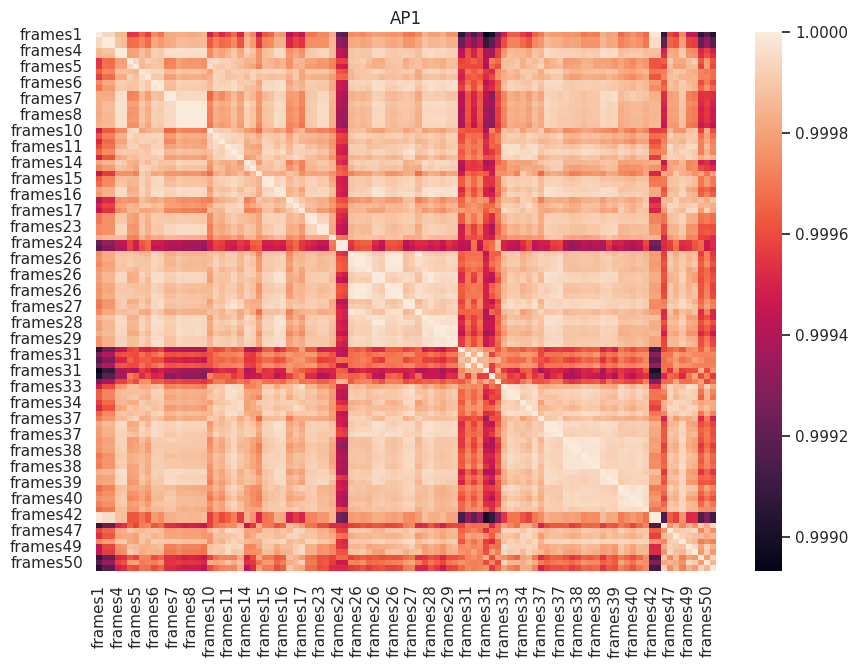

In [235]:
plt.figure(figsize = (10,7))
plt.title('AP1')
plt.xlabel('x(m)')
plt.ylabel('y(m)')
sns.heatmap(df_cm, annot=False)
#plt.savefig('heatmap.png')
plt.savefig('heatmap.pdf')

In [236]:

xs = []
ys = []
dz = []


for i in range(matrix_g.shape[0]):
    for j in range(matrix_g.shape[0]):
        if i != j:
            xs.append(i)
            ys.append(j)
            dz.append(matrix_g[i,j])

(array([0.9988, 0.999 , 0.9992, 0.9994, 0.9996, 0.9998, 1.    , 1.0002]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

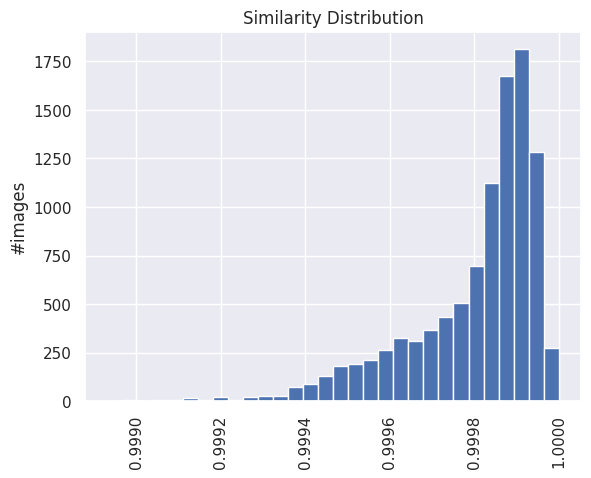

In [254]:
fig, ax = plt.subplots()
plt.hist(dz,bins=30)
ax.set_ylabel('#images')
ax.set_title('Similarity Distribution')
#ax.legend(title='Fruit color')
plt.xticks(rotation = 90)

(array([0.9993, 0.9994, 0.9995, 0.9996, 0.9997, 0.9998, 0.9999, 1.    ,
        1.0001]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

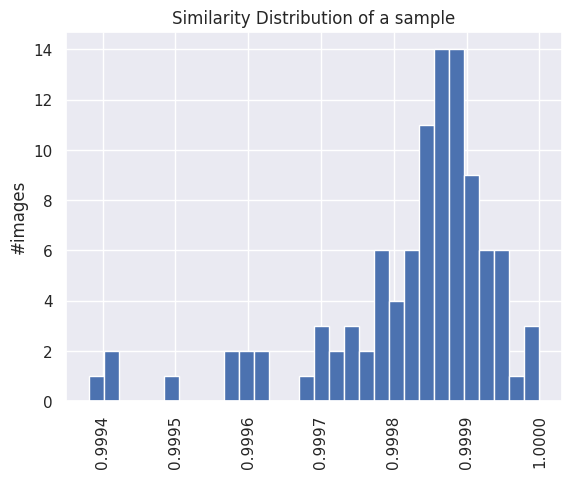

In [263]:
fig, ax = plt.subplots()
plt.hist(df_cm.iloc[[87]].values[0],bins=30)
ax.set_ylabel('#images')
ax.set_title('Similarity Distribution of a sample')
#ax.legend(title='Fruit color')
plt.xticks(rotation = 90)

In [264]:
df_cm.iloc[[87]]

frames1   frames2   frames2   frames4   frames4   frames5  \
frames40  0.999759  0.999777  0.999776  0.999895  0.999913  0.999729   

           frames5   frames5   frames5  frames6  ...  frames43  frames47  \
frames40  0.999748  0.999807  0.999736  0.99986  ...  0.999778  0.999584   

          frames47  frames48  frames48  frames49  frames49  frames49  \
frames40  0.999855  0.999831  0.999931  0.999801  0.999789  0.999596   

          frames50  frames50  
frames40   0.99968  0.999613  

[1 rows x 101 columns]

In [84]:
from PIL import Image 

In [157]:
names = list(df2["img"])


frames/frames40/30.jpg base: 


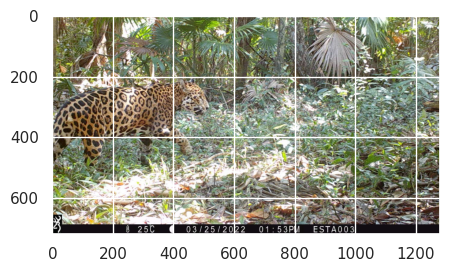

frames/frames38/120.jpg sim: 0.9999496936798096


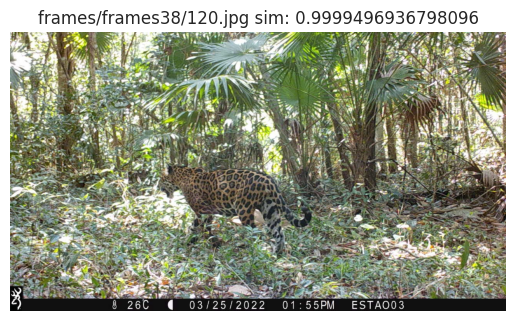

frames/frames38/150.jpg sim: 0.9999410510063171


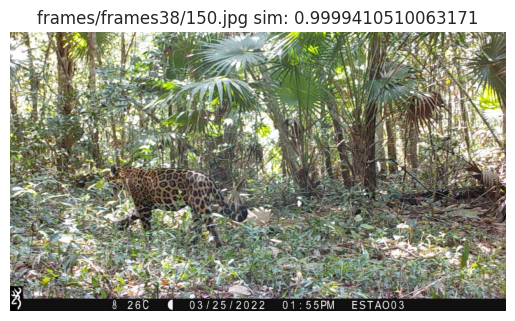

frames/frames38/180.jpg sim: 0.9999458193778992


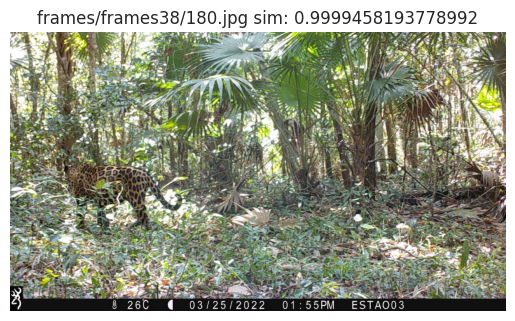

frames/frames40/120.jpg sim: 0.9999607801437378


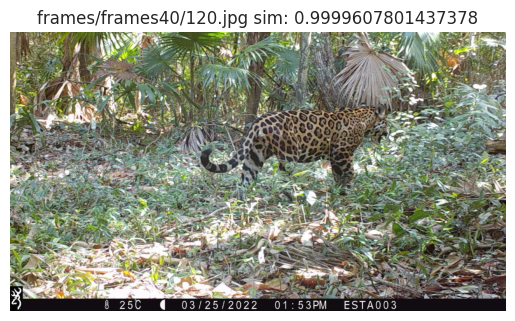

frames/frames40/150.jpg sim: 0.9999796152114868


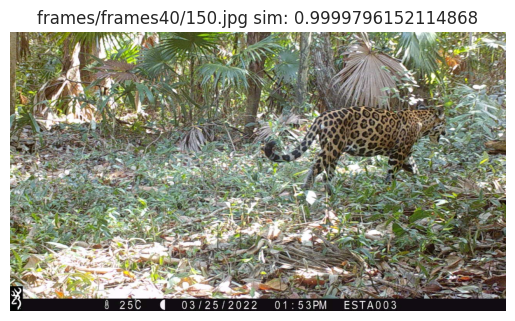

frames/frames40/30.jpg sim: 1.0000001192092896


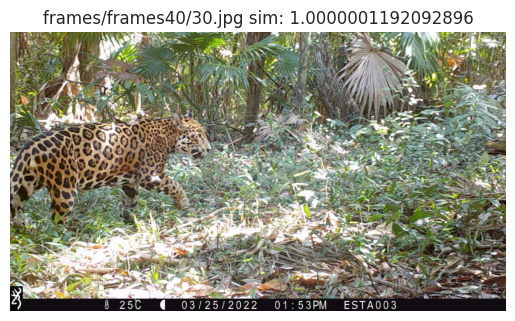

frames/frames40/60.jpg sim: 0.9999823570251465


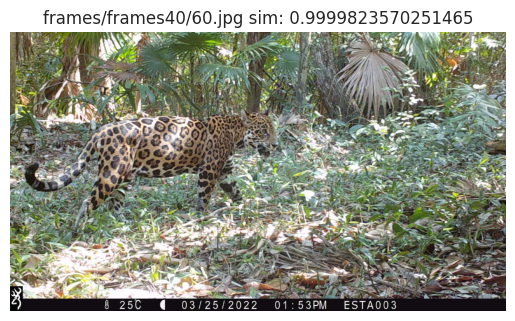

frames/frames40/90.jpg sim: 0.9999529719352722


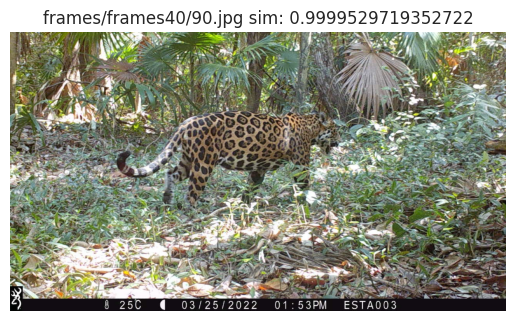

In [262]:

fig3 = plt.figure(figsize=(5,5))

n5 = 87

print(names[n5]+" base: ")
img = Image.open(names[n5])
plt.imshow(img)
plt.show();

indv_c = []

for i in range(len(df_cm.iloc[[n5]].values[0])):
    sim = df_cm.iloc[[n5]].values[0][i]
    if sim >= 0.99994:
        print(names[i]+" sim: "+str(sim))
        img = Image.open(names[i])
        indv_c.append(img)
        plt.imshow(img)
        #plt.imshow(output)
        plt.axis('off')
        plt.title(names[i]+" sim: "+str(sim)) 

        plt.show();

# Zapotal Unseen Images 

In [274]:
list(zapotal["Unnamed: 0"])

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77]

In [267]:
zapotal = pd.read_csv("csvs/zapotal_indv_try1.csv")
zapotal

Unnamed: 0                                        path
0            0                              2004PoH015.jpg
1            1                              2004PoM004.jpg
2            2                 432893_2363278_2005 (2).jpg
3            3  432893_2363278_2005_Jaguar_T35_25jun05.jpg
4            4  432893_2363278_2005_Jaguar_T35_29jun05.jpg
..         ...                                         ...
73          73                 444650_2360099_2005 (1).jpg
74          74                     444683_2363094_2009.jpg
75          75                 444736_2366258_2005 (1).jpg
76          76                 444736_2366258_2005 (2).jpg
77          77  444736_2366258_2005_Jaguar_T33_20jun05.jpg

[78 rows x 2 columns]

In [268]:
pat = "/home/ma-user/work/c_minds/pronatura/jaguares/"

testfz = np.array([preprocess_img2(pat+x) for x in list(zapotal["path"])],dtype='float32')/ 255.0


In [269]:
testfz.shape

(78, 224, 224, 3)

In [270]:
sample_size = 5000

X_train_trmz = trained_model.predict(testfz)

3/3 [==============================] - 3s 883ms/step


In [ ]:
X_train_trmz[0]

In [279]:
matrix_gz = np.zeros((X_train_trmz.shape[0],X_train_trmz.shape[0]))


In [280]:
# we need to iterate over the vector of embedding

for i in range(matrix_gz.shape[0]):
    for j in range(X_train_trmz.shape[0]):
        matrix_gz[i,j] = f(X_train_trmz[i],X_train_trmz[j])

#>matrix_g

In [281]:

df_cmz = pd.DataFrame(matrix_gz, index = [i for i in list(zapotal["Unnamed: 0"])],
                  columns = [i for i in list(zapotal["Unnamed: 0"])])
df_cmz

0         1         2         3         4         5         6   \
0   1.000000  0.999727  0.999260  0.999068  0.999187  0.999445  0.999306   
1   0.999727  1.000000  0.999466  0.999349  0.999433  0.999608  0.999499   
2   0.999260  0.999466  1.000000  0.999898  0.999924  0.999941  0.999949   
3   0.999068  0.999349  0.999898  1.000000  0.999981  0.999853  0.999883   
4   0.999187  0.999433  0.999924  0.999981  1.000000  0.999909  0.999931   
..       ...       ...       ...       ...       ...       ...       ...   
73  0.999627  0.999498  0.999092  0.999037  0.999093  0.999208  0.999054   
74  0.999228  0.999433  0.999925  0.999894  0.999929  0.999931  0.999944   
75  0.999409  0.999486  0.999448  0.999493  0.999504  0.999481  0.999393   
76  0.999567  0.999631  0.999852  0.999830  0.999851  0.999860  0.999831   
77  0.999789  0.999775  0.999391  0.999269  0.999383  0.999563  0.999437   

          7         8         9   ...        68        69        70        71  \
0   0.999522  0.999575  0.999597  ...  0.999649  0.999456  0.999357  0.999381   
1   0.999629  0.999303  0.999467  ...  0.999736  0.999613  0.999393  0.999573   
2   0.999834  0.999170  0.999497  ...  0.999801  0.999813  0.999314  0.999890   
3   0.999822  0.999001  0.999420  ...  0.999734  0.999833  0.999400  0.999879   
4   0.999839  0.999086  0.999461  ...  0.999775  0.999847  0.999414  0.999908   
..       ...       ...       ...  ...       ...       ...       ...       ...   
73  0.999532  0.999589  0.999710  ...  0.999533  0.999475  0.999632  0.999341   
74  0.999797  0.999120  0.999427  ...  0.999738  0.999794  0.999289  0.999897   
75  0.999718  0.999225  0.999509  ...  0.999585  0.999626  0.999638  0.999694   
76  0.999922  0.999444  0.999726  ...  0.999909  0.999893  0.999630  0.999860   
77  0.999642  0.999455  0.999560  ...  0.999625  0.999571  0.999285  0.999595   

          72        73        74        75        76        77  
0   0.999729  0.999627  0.999228  0.999409  0.999567  0.999789  
1   0.999715  0.999498  0.999433  0.999486  0.999631  0.999775  
2   0.999672  0.999092  0.999925  0.999448  0.999852  0.999391  
3   0.999597  0.999037  0.999894  0.999493  0.999830  0.999269  
4   0.999650  0.999093  0.999929  0.999504  0.999851  0.999383  
..       ...       ...       ...       ...       ...       ...  
73  0.999615  1.000000  0.999005  0.999636  0.999457  0.999581  
74  0.999621  0.999005  1.000000  0.999432  0.999804  0.999395  
75  0.999550  0.999636  0.999432  1.000000  0.999679  0.999535  
76  0.999865  0.999457  0.999804  0.999679  1.000000  0.999609  
77  0.999679  0.999581  0.999395  0.999535  0.999609  1.000000  

[78 rows x 78 columns]

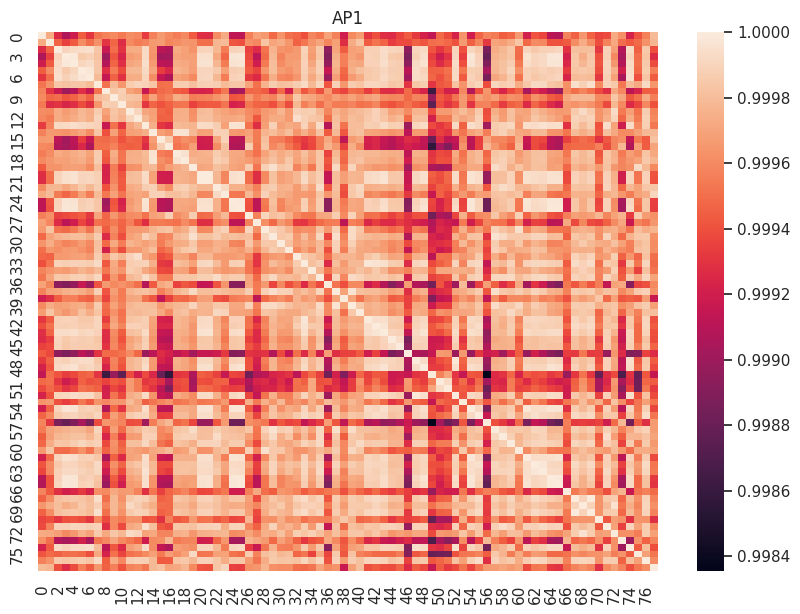

In [283]:
plt.figure(figsize = (10,7))
plt.title('AP1')
plt.xlabel('x(m)')
plt.ylabel('y(m)')
sns.heatmap(df_cmz, annot=False)
#plt.savefig('heatmap.png')
plt.savefig('heatmap.pdf')

In [284]:

xsz = []
ysz = []
dzz = []


for i in range(matrix_gz.shape[0]):
    for j in range(matrix_gz.shape[0]):
        if i != j:
            xsz.append(i)
            ysz.append(j)
            dzz.append(matrix_gz[i,j])

(array([0.99825, 0.9985 , 0.99875, 0.999  , 0.99925, 0.9995 , 0.99975,
        1.     , 1.00025]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

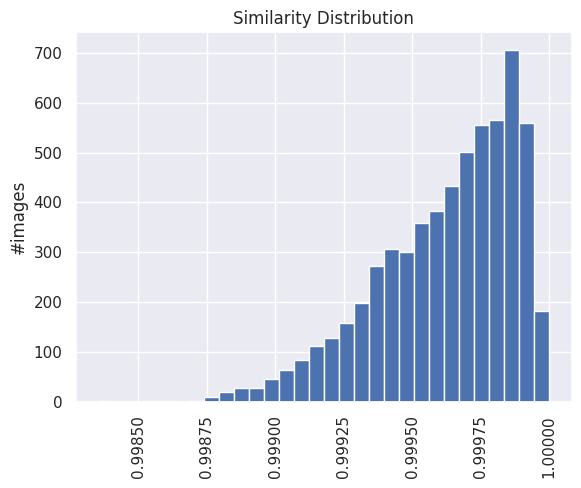

In [285]:
fig, ax = plt.subplots()
plt.hist(dzz,bins=30)
ax.set_ylabel('#images')
ax.set_title('Similarity Distribution')
#ax.legend(title='Fruit color')
plt.xticks(rotation = 90)

In [327]:

n5 = 73

In [328]:
df_cmz.iloc[[n5]]

0         1         2         3         4         5         6   \
73  0.999627  0.999498  0.999092  0.999037  0.999093  0.999208  0.999054   

          7         8        9   ...        68        69        70        71  \
73  0.999532  0.999589  0.99971  ...  0.999533  0.999475  0.999632  0.999341   

          72   73        74        75        76        77  
73  0.999615  1.0  0.999005  0.999636  0.999457  0.999581  

[1 rows x 78 columns]

(array([0.9986, 0.9988, 0.999 , 0.9992, 0.9994, 0.9996, 0.9998, 1.    ,
        1.0002]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

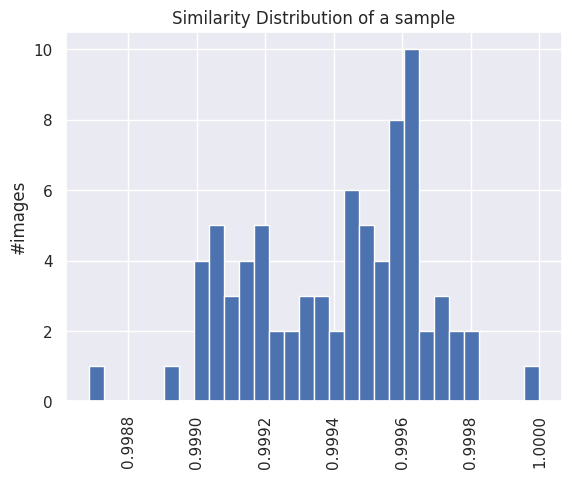

In [329]:
fig, ax = plt.subplots()
plt.hist(df_cmz.iloc[[n5]].values[0],bins=30)
ax.set_ylabel('#images')
ax.set_title('Similarity Distribution of a sample')
#ax.legend(title='Fruit color')
plt.xticks(rotation = 90)

In [330]:
namesz = [pat+x for x in list(zapotal["path"])]

/home/ma-user/work/c_minds/pronatura/jaguares/444650_2360099_2005 (1).jpg base: 


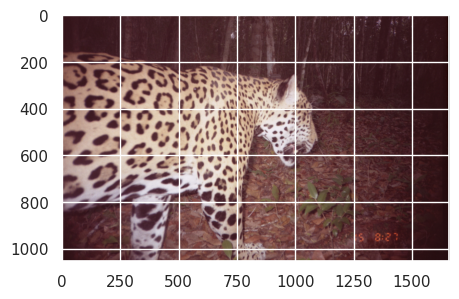

/home/ma-user/work/c_minds/pronatura/jaguares/434051.718_2361572.69_2017 (37).jpg sim: 0.9997103810310364


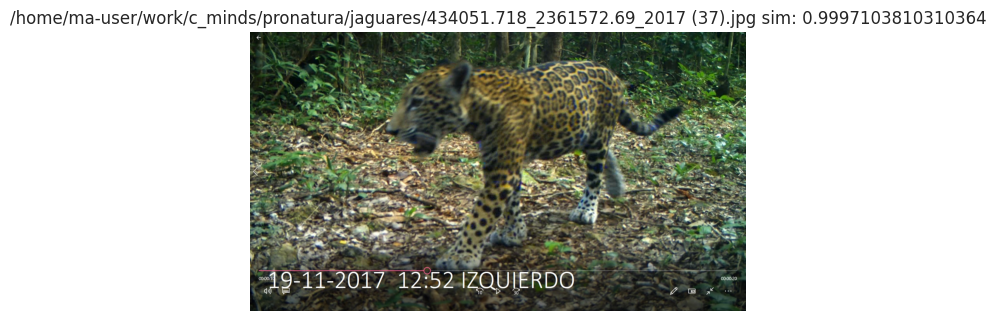

/home/ma-user/work/c_minds/pronatura/jaguares/436042_2362090_2006 (21).jpg sim: 0.9997808337211609


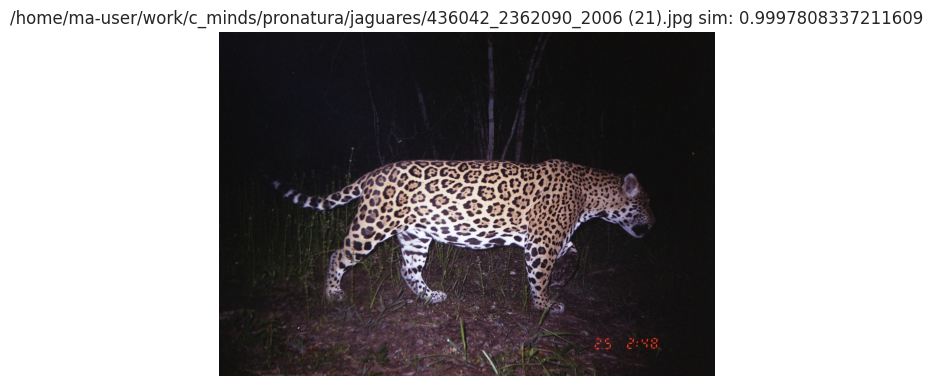

/home/ma-user/work/c_minds/pronatura/jaguares/436042_2362090_2007 (1).jpg sim: 0.9997602701187134


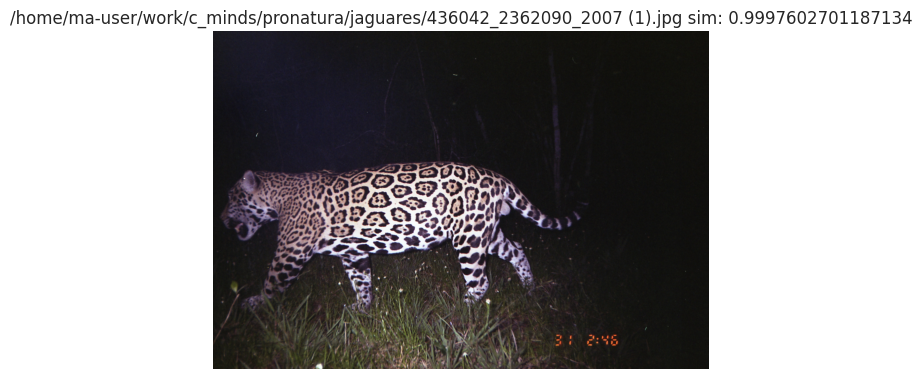

/home/ma-user/work/c_minds/pronatura/jaguares/436042_2362090_2007 (10).jpg sim: 0.9997079968452454


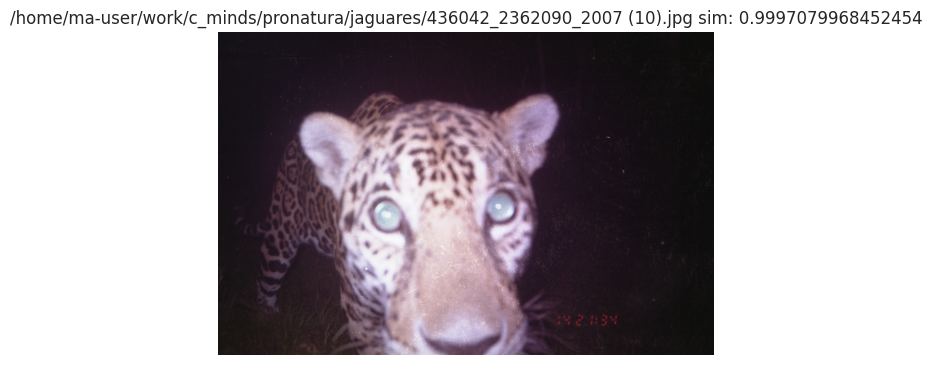

/home/ma-user/work/c_minds/pronatura/jaguares/437501_2363026_2006 (3).jpg sim: 0.9997194409370422


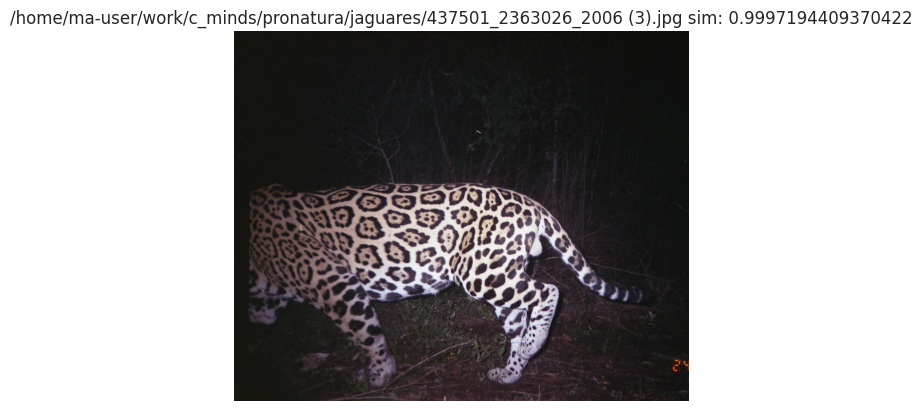

/home/ma-user/work/c_minds/pronatura/jaguares/439643_2362963_2004_Jaguar 3_1 .jpg sim: 0.9997831583023071


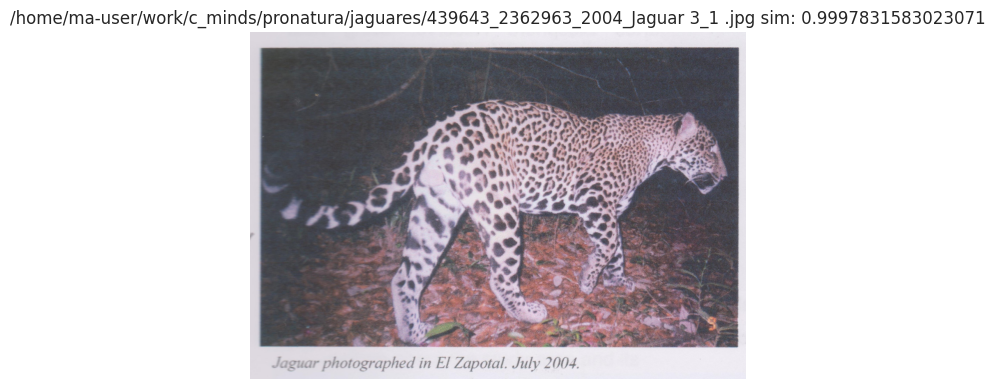

/home/ma-user/work/c_minds/pronatura/jaguares/442621_2362679_2004_PoM008.jpg sim: 0.9997674822807312


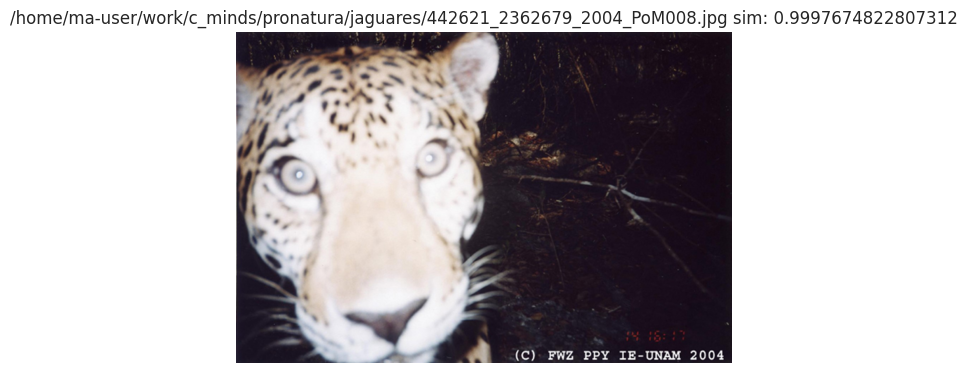

/home/ma-user/work/c_minds/pronatura/jaguares/444650_2360099_2005 (1).jpg sim: 1.0000001192092896


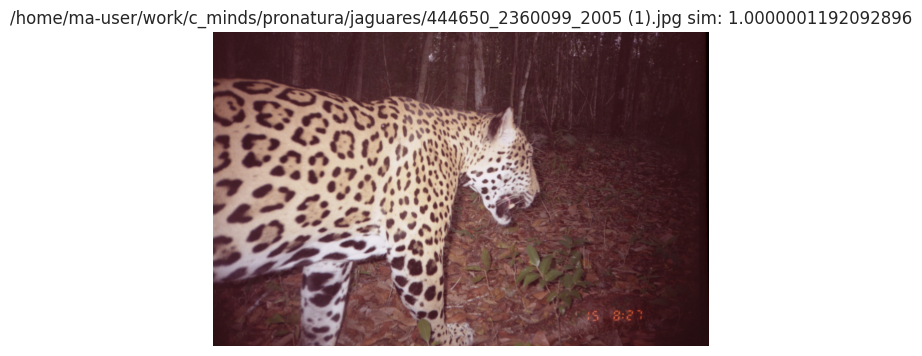

In [333]:

fig3 = plt.figure(figsize=(5,5))

#n5 = 87

print(namesz[n5]+" base: ")
img = Image.open(namesz[n5])
plt.imshow(img)
plt.show();

indv_c = []

for i in range(len(df_cmz.iloc[[n5]].values[0])):
    sim = df_cmz.iloc[[n5]].values[0][i]
    if sim >= 0.9997:
        print(namesz[i]+" sim: "+str(sim))
        img = Image.open(namesz[i])
        indv_c.append(img)
        plt.imshow(img)
        #plt.imshow(output)
        plt.axis('off')
        plt.title(namesz[i]+" sim: "+str(sim)) 

        plt.show();